In [5]:
"""
广发证券-行为金融研究系列之六：A股羊群效应投资策略研究-201102
CSAD 方法
羊群效应中是过去1周的周涨幅与x比较
以周为单位，数据来自wind
"""
import pandas as pd
import numpy as np
import akshare as ak
import statsmodels.formula.api as smf
import datetime
import math
import matplotlib.pyplot as plt
class Herd_Effect(object):
    def __init__(self, params_grids):
        self.cash = params_grids['cash']
        self.capacity = params_grids['capacity']
        self.sector_code_list = ak.sw_index_spot()['指数代码']        
        self.pa = 0.7 # 检测A周区间内是否存在羊群效应
        self.N = 3 # 选取有羊群效应的N个行业
        self.x = 4 # 有羊群效应的行业近期涨幅不应高于x
        self.Y = 11 # 龙头股涨幅应大于Y
        self.Z = 4 # 选取买入的股票周涨幅不应超过z
        self.M = 5 # 每个行业选择不超过M只股票

        self.sector_pctchange = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock_beta/sector_weekly_pctchange.csv')
        self.all_stock_price_data = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock-Daily-Close-XXXXXX.csv',dtype=str)
        self.stock_weekly_chg = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock-Weekly-Change.csv')
        self.sector_pctchange.set_index(['date'],inplace=True)
        self.all_stock_price_data.set_index(['date'],inplace=True)
        self.stock_weekly_chg.set_index(['date'],inplace=True)
    
    def Herd_Testing(self, sector_code, date_now):
        """
        给定的行业指数sector_code，时间区间beginning至date_now，以CSSD检测是否存在羊群效应
        """
        OLS_data = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/CSSD method/' + sector_code + '.csv').set_index('Date')
        para = OLS_data.loc[date_now,['DU_para']].values[0]
        pvalue = OLS_data.loc[date_now,['DU_p_value']].values[0]
        
        RI = pd.read_excel('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Rm Ri weekly change.xlsx',sheet_name = 'Ri').set_index('Date')
        A_weeks_sector_change = self.sector_pctchange.loc[date_now, sector_code]
        p_value = self.pa
        if para < 0 and pvalue <= p_value and A_weeks_sector_change < self.x : 
            return True,pvalue
        else:
            return False, pvalue
    
    def Leading_Testing(self,sector_code, date_now) : 
        """
        对sector下所有成分股筛选龙头股
        """
        stock_list = pd.read_csv('D:\\Python\\Flies\\Guanyun\\A股数据\\申万一级行业成份\\'+ sector_code +'.csv',dtype=str)
        for stock in stock_list['stock_code'] : 
            try:
                if self.stock_weekly_chg.loc[date_now,stock] > self.Y: 
                    return 1
            except : 
                print(stock,'has no data in date:',date_now)
        return 0  # 当前区间股票尚未发售等原因，无法提取数据
    
    def Choose_Stock(self, sector_code, date_now):
        """
        在已选行业，筛选(Ri − RI)^2小且周涨跌幅低于Z的个股，数量不超过M
        """
        stock_choose_list = pd.DataFrame(columns=['stock','CSSD_i'])
        stock_list = pd.read_csv('D:\\Python\\Flies\\Guanyun\\A股数据\\申万一级行业成份\\'+ sector_code +'.csv',dtype=str)['stock_code']
        stock_CSSD_i = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/CSSD method/Stock_CSSD/'+ sector_code +'.csv',dtype=str).set_index('Date')
        for stock in stock_list : 
            stock_chg = self.stock_weekly_chg.loc[date_now, stock]
            if stock_chg < self.Z : 
                CSSD_i = stock_CSSD_i.loc[date_now, stock]
                stock_choose_list = stock_choose_list.append([{'stock':stock,'CSSD_i':CSSD_i}], ignore_index=True)
            
        if len(stock_choose_list) > self.M: 
            stock_choose_list = stock_choose_list.sort_values(by='CSSD_i',ascending=True)
            stock_choose_list = stock_choose_list.iloc[:self.M]
        return stock_choose_list['stock'].values

    def close_today(self, stock, date_now, method = 'next'):
        """
        默认获取最近一个交易日的close,stock为sh/sz+XXXXXX，method = next 时获取下一交易日的close
        """
        if method == 'lastest' : 
            day_1_stock = self.all_stock_price_data[(self.all_stock_price_data.index <= date_now)][stock].sort_index()
            day_1_stock = day_1_stock.dropna(how='any')
            return float(day_1_stock.iloc[-1])
        elif method == 'next' : 
            day_1_stock = self.all_stock_price_data[(self.all_stock_price_data.index >= date_now)][stock].sort_index()
            day_1_stock = day_1_stock.dropna(how='any')
            return float(day_1_stock.iloc[0])
    
    def trade( self, trade_list, cash, one_week_ago, date_now ):
        """
        通过index分别为收益，权重，买价，卖价的dataframe['return_chg','weight','close_when_buying','close_when_selling']
        记录持有股票的情况，每次换仓时结算换仓前持有的资产价值，并根据权重配比下一期的投资份额
        """
        # 获取换仓前的总资产
        return_sum = cash
        for stock in trade_list.columns.values : 
            trade_list.loc['close_when_selling'][stock] = self.close_today(stock, date_now)
            change = trade_list.loc['close_when_selling'][stock] / trade_list.loc['close_when_buying'][stock]
            return_sum +=  trade_list.loc['return_chg'][stock] * change
        # 清空trade_list中的stock
        trade_list = pd.DataFrame( index = ['return_chg','weight','close_when_buying','close_when_selling'] )
        return_sum_now = return_sum
        # 换仓
        
        herd_sector_list = pd.DataFrame(columns = ['sector','p_value'])

        for sector_code in self.sector_code_list : 
            herd = self.Herd_Testing(sector_code,  date_now)  # herd(tuple): herd[1]: True/False; [2]: parameter; [3]: p-value
            if herd[0] == True :  # 如果呈现出羊群效应，就检测龙头股数量
                if self.Leading_Testing(sector_code, date_now) == 1 :  # 且有龙头股数量也合适，买入
                    herd_sector_list = herd_sector_list.append([{'sector':sector_code,'p_value':herd[1]}], ignore_index=True)
        if len(herd_sector_list) > self.N: 
            herd_sector_list = herd_sector_list.sort_values(by='p_value',ascending=True)
            herd_sector_list = herd_sector_list.iloc[:self.N]
            
        for sector_code in herd_sector_list['sector'] : 
            choose_stock_list = self.Choose_Stock(sector_code, date_now)
            weight = 1 - ( herd_sector_list[herd_sector_list['sector'] == sector_code]['p_value'].values[0] )
            # 处理trade_list，新添入各龙头股
            for stock in choose_stock_list : 
                trade_list[stock] = None
                trade_list[stock]['close_when_buying'] = self.close_today(stock, date_now,'next')
                trade_list[stock]['weight'] = weight / len(choose_stock_list)
        weight_sum = trade_list.loc['weight'].sum() # 权重加总求权重的和，各个指数的权重为 权重/总权重和
        
        # 以weight权重分配现有资金return_sum
        for stock in trade_list.columns.values : 
            trade_list[stock]['return_chg'] = return_sum_now * ( trade_list[stock]['weight'] / weight_sum )
            return_sum -= trade_list[stock]['return_chg']
        return trade_list, return_sum    

    def display_performance(self, trade_list, performance_list, cash, one_week_ago, date_now) : 
        """
        通过index分别为收益，权重，买价，卖价的dataframe['return_chg','weight','close_when_buying','close_when_selling']
        在持有期内每天用当天的收盘价与买价比较，在performance_list中记录持有资产的每日价值变化
        """        
        # 获取交易日
        date_interval =self.all_stock_price_data[(self.all_stock_price_data.index <= date_now) &\
                                                 (self.all_stock_price_data.index >= one_week_ago)].sort_index().index.values
        
        for date in date_interval:
            if len(trade_list.columns.values) == 0 :  # 如果本月空仓
                performance_list.loc[date] = cash
            else: 
                capacity_num = cash
                for stock in trade_list.columns.values : 
                    trade_list.loc['close_when_selling'][stock] = self.close_today(stock, date,'next')
                    change = trade_list.loc['close_when_selling'][stock] / trade_list.loc['close_when_buying'][stock]
                    capacity_num +=  trade_list.loc['return_chg'][stock] * change
                performance_list.loc[date] = capacity_num
        print("_______________________________")
        print(one_week_ago, date_now)
        print(trade_list)
        print(date_now,performance_list.iloc[-1])
        print("_______________________________")

    
    def run(self):
        # 创建日期list : date_list
        date_list = self.sector_pctchange.index.to_list()
        # 创建trade_list
        trade_list = pd.DataFrame( index = ['return_chg','weight','close_when_buying','close_when_selling'] )
        
        # 创建performance_list
        performance_list = pd.DataFrame(columns=['capacity'])
        cash = self.cash

        # 对于date_list中的每一个时间段，判断是否达到信号进行交易，并检测保存下一时间段的performance
        for i in range(len(date_list)-2) : 
            trade_list, cash = self.trade(trade_list, cash, date_list[i], date_list[i+1] )
            if i != len(date_list)-3 : 
                self.display_performance( trade_list, performance_list,cash, date_list[i+1], date_list[i+2])
        return performance_list
        
        
if __name__ == '__main__':
    
    parameters_grid_dict = {
        'cash' : 1000000,
        'capacity' : 1000000,
        'beginning_date' : '2015-01-15',
        'ending_date' : '2020-01-01',
        'A' : 60,  # 检测A周区间内是否存在羊群效应
        'N' : 2,  # 选取有羊群效应的N个行业
        'x' : 13,  # 有羊群效应的行业近期涨幅不应高于x
        'Y' : 11,  # 龙头股涨幅应大于Y
        'Z' : 11, # 选取买入的股票周涨幅不应超过z
        'M' : 6 # 每个行业选择不超过M只股票
        }
    
    ml = Herd_Effect(params_grids=parameters_grid_dict)
    output = ml.run()


_______________________________
2015-01-16 2015-01-23
                      600506    002100    002567    600354    600540
return_chg          200000.0  200000.0  200000.0  200000.0  200000.0
weight              0.168456  0.168456  0.168456  0.168456  0.168456
close_when_buying      11.98    5.8012    5.4861       8.8    6.4118
close_when_selling     12.62    5.9962     5.516      8.98    6.5886
2015-01-23 capacity    1.028103e+06
Name: 2015-01-23, dtype: float64
_______________________________
_______________________________
2015-01-23 2015-01-30
                           300087         300138         002286  \
return_chg          139713.823261  139713.823261  139713.823261   
weight                   0.166634       0.166634       0.166634   
close_when_buying          4.2823         4.6708         8.1085   
close_when_selling          4.726         4.7487         8.1567   

                           002696         000702        000016        002668  \
return_chg          139713.823

_______________________________
2015-04-03 2015-04-10
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2015-04-10 capacity    1.174269e+06
Name: 2015-04-10, dtype: float64
_______________________________
_______________________________
2015-04-10 2015-04-17
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2015-04-17 capacity    1.174269e+06
Name: 2015-04-17, dtype: float64
_______________________________
_______________________________
2015-04-17 2015-04-24
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2015-04-24 capacity    1.174269e+06
Name: 2015-04-24, dtype: float64
_______________________________
_______________________________
2015-04-24 2015-04-30
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2015-04-30 capacity    1.174269e+06
Name: 2015-04-30, dtype: float64
_______________________________


_______________________________
2015-08-07 2015-08-14
                          000156        600757        002103        002123  \
return_chg          290030.39696  290030.39696  290030.39696  290030.39696   
weight                  0.076955      0.076955      0.076955      0.076955   
close_when_buying         29.152        8.8846       14.1032       19.7564   
close_when_selling       31.3144        9.5487       15.7685       23.4465   

                          600636  
return_chg          290030.39696  
weight                  0.076955  
close_when_buying        15.0671  
close_when_selling       17.7944  
2015-08-14 capacity    1.634262e+06
Name: 2015-08-14, dtype: float64
_______________________________
_______________________________
2015-08-14 2015-08-21
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2015-08-21 capacity    1.634262e+06
Name: 2015-08-21, dtype: float64
_______________________________
_____________________________

_______________________________
2015-11-13 2015-11-20
                           600482         600893         002389  \
return_chg          315377.829763  315377.829763  315377.829763   
weight                   0.099713       0.099713       0.099713   
close_when_buying         39.9064        49.3681        21.3489   
close_when_selling        41.4567        51.2327         20.972   

                           000519         600072  
return_chg          315377.829763  315377.829763  
weight                   0.099713       0.099713  
close_when_buying         18.3866        25.8338  
close_when_selling        18.3866        25.8338  
2015-11-20 capacity    1.595485e+06
Name: 2015-11-20, dtype: float64
_______________________________
_______________________________
2015-11-20 2015-11-27
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2015-11-27 capacity    1.595485e+06
Name: 2015-11-27, dtype: float64
_______________________________
____

_______________________________
2015-12-31 2016-01-08
                           300197         002051         603698  \
return_chg          118570.500084  118570.500084  118570.500084   
weight                   0.193963       0.193963       0.193963   
close_when_buying          6.7758        16.0165         26.153   
close_when_selling          5.766        16.0607        21.4671   

                           002047         600496        601888        002159  \
return_chg          118570.500084  118570.500084  105263.86613  105263.86613   
weight                   0.193963       0.193963      0.172195      0.172195   
close_when_buying         10.9571         5.9267       28.2983          30.8   
close_when_selling         9.9725         5.8084       25.5406         24.59   

                          601007        002306        000430         000935  \
return_chg          105263.86613  105263.86613  105263.86613  102421.008102   
weight                  0.172195      0.172195     

_______________________________
2016-02-05 2016-02-19
                          600846        002541        002586        603018  \
return_chg          97886.217098  97886.217098  97886.217098  97886.217098   
weight                  0.167172      0.167172      0.167172      0.167172   
close_when_buying         7.4215        9.6638        8.9303        8.2027   
close_when_selling        8.9258       10.1221       10.1575        8.6468   

                          603030        000619        002043        600321  \
return_chg          97886.217098  86938.304639  86938.304639  86938.304639   
weight                  0.167172      0.148475      0.148475      0.148475   
close_when_buying          8.429        9.2325        6.2323        3.3935   
close_when_selling        9.4133         9.754        7.3089        3.6324   

                          002233        600883        600569        600307  \
return_chg          86938.304639  86938.304639  64679.315347  64679.315347   
weight  

_______________________________
2016-04-01 2016-04-08
                           600784         600051         600139  \
return_chg          111128.203028  111128.203028  111128.203028   
weight                   0.156014       0.156014       0.156014   
close_when_buying          8.5422         9.0484          10.79   
close_when_selling         8.4628         9.0662          12.31   

                           000409         000638        000978        600258  \
return_chg          111128.203028  111128.203028  92357.711449  92357.711449   
weight                   0.156014       0.156014      0.129662      0.129662   
close_when_buying          9.4305           27.5       11.1641       14.9816   
close_when_selling         9.4305           27.5       11.1447       14.9816   

                          601888        600138        601007        600127  \
return_chg          92357.711449  92357.711449  92357.711449  92064.751315   
weight                  0.129662      0.129662      0

_______________________________
2016-05-27 2016-06-03
                           000505         002567         000911  \
return_chg          291503.839692  291503.839692  291503.839692   
weight                   0.071316       0.071316       0.071316   
close_when_buying            9.84         8.5041          20.71   
close_when_selling           9.84         8.5041          20.71   

                           002069         002299  
return_chg          291503.839692  291503.839692  
weight                   0.071316       0.071316  
close_when_buying             8.3        21.2236  
close_when_selling            8.3        21.2068  
2016-06-03 capacity    1.457288e+06
Name: 2016-06-03, dtype: float64
_______________________________
_______________________________
2016-06-03 2016-06-08
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2016-06-08 capacity    1.457288e+06
Name: 2016-06-08, dtype: float64
_______________________________
____

_______________________________
2016-08-26 2016-09-02
                           002700         600578         002610  \
return_chg          103857.083089  103857.083089  103857.083089   
weight                   0.102509       0.102509       0.102509   
close_when_buying         14.3778         3.8783         4.6045   
close_when_selling        14.3877          3.834         4.6045   

                           002608         002266        601169        601988  \
return_chg          103857.083089  103857.083089  99854.137565  99854.137565   
weight                   0.102509       0.102509      0.098558      0.098558   
close_when_buying           10.75         5.2924        6.1829        2.6694   
close_when_selling          10.75         5.2924        6.3081        2.6849   

                          601939        601288        601328        000408  \
return_chg          99854.137565  99854.137565  99854.137565  97361.043511   
weight                  0.098558      0.098558      0

_______________________________
2016-09-30 2016-10-14
                           600644         601158         600027  \
return_chg          117654.566123  117654.566123  117654.566123   
weight                   0.173383       0.173383       0.173383   
close_when_buying            8.97         5.6822         4.5108   
close_when_selling           8.87         6.5326         4.5746   

                           000601         002672       600697       600858  \
return_chg          117654.566123  117654.566123  99953.95335  99953.95335   
weight                   0.173383       0.173383     0.147298     0.147298   
close_when_buying          8.4842        18.3042      29.7337       8.6625   
close_when_selling         8.6414        19.5626      29.9844       8.7313   

                         002336       600785       600828        000498  \
return_chg          99953.95335  99953.95335  99953.95335  76386.054641   
weight                 0.147298     0.147298     0.147298      0.1125

_______________________________
2016-11-11 2016-11-18
                           000759         600628         000861  \
return_chg          110910.235995  110910.235995  110910.235995   
weight                   0.177175       0.177175       0.177175   
close_when_buying          7.9829        14.2719         5.0822   
close_when_selling         8.0886        14.1776         5.0526   

                           600697         000061         002482  \
return_chg          110910.235995  110910.235995  109579.528602   
weight                   0.177175       0.177175       0.175049   
close_when_buying         32.2309        12.3888          9.305   
close_when_selling        32.7972        12.3204         9.4419   

                           600133         002062         600853  \
return_chg          109579.528602  109579.528602  109579.528602   
weight                   0.175049       0.175049       0.175049   
close_when_buying          8.4978         6.9008         4.3945   
close_

_______________________________
2016-12-16 2016-12-23
                           000589         601058         600731  \
return_chg          124530.568064  124530.568064  124530.568064   
weight                    0.18691        0.18691        0.18691   
close_when_buying          5.6616         3.9325         7.7594   
close_when_selling         5.6133          3.877         7.8053   

                           600387         300107         601800  \
return_chg          124530.568064  124530.568064  117871.921907   
weight                    0.18691        0.18691       0.176916   
close_when_buying         13.9543         6.3025         13.057   
close_when_selling        14.4184         6.3972        13.8115   

                           000498         600846         002713  \
return_chg          117871.921907  117871.921907  117871.921907   
weight                   0.176916       0.176916       0.176916   
close_when_buying          7.3531         8.4544        15.0174   
close_

_______________________________
2017-01-20 2017-01-26
                           600165         000096         002324  \
return_chg          113917.279875  113917.279875  113917.279875   
weight                   0.176378       0.176378       0.176378   
close_when_buying           11.85        14.8347         7.3185   
close_when_selling          12.59         15.447         7.5485   

                           002470         002455         603698  \
return_chg          113917.279875  113917.279875  111262.496668   
weight                   0.176378       0.176378       0.172267   
close_when_buying          7.2148        11.2118        21.0823   
close_when_selling         7.2929        11.6003        21.1876   

                           300355         601390         600209  \
return_chg          111262.496668  111262.496668  111262.496668   
weight                   0.172267       0.172267       0.172267   
close_when_buying          5.5747         8.1753        12.5409   
close_

_______________________________
2017-03-03 2017-03-10
                           002051         002307         002375  \
return_chg          128196.675779  128196.675779  128196.675779   
weight                   0.139746       0.139746       0.139746   
close_when_buying         19.6447         8.1096        10.7417   
close_when_selling        19.2526         7.8607        10.7711   

                           300284         603828         300055  \
return_chg          128196.675779  128196.675779  102556.700704   
weight                   0.139746       0.139746       0.111796   
close_when_buying         11.4006         8.1502        16.4381   
close_when_selling        11.1511         8.1697        16.9728   

                           600635         600803         600027  \
return_chg          102556.700704  102556.700704  102556.700704   
weight                   0.111796       0.111796       0.111796   
close_when_buying          6.1391        13.1631         4.7659   
close_

_______________________________
2017-04-07 2017-04-14
                         300274       002058       002533       601877  \
return_chg          149058.0226  149058.0226  149058.0226  149058.0226   
weight                 0.140278     0.140278     0.140278     0.140278   
close_when_buying       10.1417      26.8806        8.393      18.6764   
close_when_selling       9.8391      25.6039        8.119      18.3322   

                         300105         600448         002144         002029  \
return_chg          149058.0226  100002.939476  100002.939476  100002.939476   
weight                 0.140278       0.094112       0.094112       0.094112   
close_when_buying        7.8368         6.0691        20.4408        10.0482   
close_when_selling       7.8082         5.8607        19.9125         9.8305   

                           000850         601339        600880        603999  \
return_chg          100002.939476  100002.939476  98808.952386  98808.952386   
weight        

_______________________________
2017-05-12 2017-05-19
                           002531         002451         300444  \
return_chg          113675.101746  113675.101746  113675.101746   
weight                   0.141146       0.141146       0.141146   
close_when_buying          6.2701        19.0934        11.5595   
close_when_selling         6.5079        20.3928        11.0947   

                           300393         600973         603658  \
return_chg          113675.101746  113675.101746  109777.774649   
weight                   0.141146       0.141146       0.136306   
close_when_buying         12.6537         5.5121        29.6641   
close_when_selling        12.8761         5.5405        29.2221   

                           002793         603567         600055  \
return_chg          109777.774649  109777.774649  109777.774649   
weight                   0.136306       0.136306       0.136306   
close_when_buying         15.5202        15.5649        11.7886   
close_

_______________________________
2017-06-16 2017-06-23
                           600129         300016         600513  \
return_chg          109003.800478  109003.800478  109003.800478   
weight                   0.149813       0.149813       0.149813   
close_when_buying           12.94         9.9172         9.9358   
close_when_selling        12.7652         9.6508         9.7215   

                           300358         000705         601222  \
return_chg          109003.800478  109003.800478  101897.572053   
weight                   0.149813       0.149813       0.140046   
close_when_buying          14.409         9.9996         7.1186   
close_when_selling        14.1623          9.802         6.8722   

                           600379         300593         603606  \
return_chg          101897.572053  101897.572053  101897.572053   
weight                   0.140046       0.140046       0.140046   
close_when_buying          9.4881        11.4834         6.3322   
close_

_______________________________
2017-07-21 2017-07-28
                          300138        000713        000972        300189  \
return_chg          100949.10861  100949.10861  100949.10861  100949.10861   
weight                  0.196797      0.196797      0.196797      0.196797   
close_when_buying          8.119        6.0165           4.0           3.2   
close_when_selling        8.1121        6.0932          3.98          3.34   

                          002157        000400        600537        002527  \
return_chg          100949.10861  99413.222892  99413.222892  99413.222892   
weight                  0.196797      0.193802      0.193802      0.193802   
close_when_buying          4.164       16.7373        4.6519       10.0293   
close_when_selling        4.4051       16.9529        4.8205        10.236   

                          300040        300068        300179        002347  \
return_chg          99413.222892  99413.222892  94877.188928  94877.188928   
weight  

_______________________________
2017-08-25 2017-09-01
                           000559         000338         000903  \
return_chg          115402.212258  115402.212258  115402.212258   
weight                   0.186768       0.186768       0.186768   
close_when_buying         10.1835         6.1013         4.0139   
close_when_selling          9.931         6.4016          3.956   

                           002085         000996        300283        600241  \
return_chg          115402.212258  115402.212258  101016.27586  101016.27586   
weight                   0.186768       0.186768      0.163486      0.163486   
close_when_buying          15.895          13.85        6.8692       11.8396   
close_when_selling        16.6692          13.95        7.0285       12.1887   

                          002090        002169        600580        603663  \
return_chg          101016.27586  101016.27586  101016.27586  96913.045438   
weight                  0.163486      0.163486      0

_______________________________
2017-09-29 2017-10-13
                           002443         600808         600019  \
return_chg          108422.823276  108422.823276  108422.823276   
weight                   0.193132       0.193132       0.193132   
close_when_buying          8.5557         3.8492         6.1477   
close_when_selling         8.6753          3.799         6.2642   

                           000898         000959        601677        600768  \
return_chg          108422.823276  108422.823276  99497.477737  99497.477737   
weight                   0.193132       0.193132      0.177233      0.177233   
close_when_buying          4.5209           6.91       13.0584          15.6   
close_when_selling         4.5968           6.98        13.163         16.08   

                          601899        600516        603826        300165  \
return_chg          99497.477737  99497.477737  99497.477737  96611.979907   
weight                  0.177233      0.177233      0

_______________________________
2017-11-10 2017-11-17
                           000668         600246         002133  \
return_chg          100792.257348  100792.257348  100792.257348   
weight                   0.196068       0.196068       0.196068   
close_when_buying         16.1599         4.1364         4.8144   
close_when_selling        15.2362         3.8055         4.5428   

                           600743         600773       300648       300228  \
return_chg          100792.257348  100792.257348  96779.07755  96779.07755   
weight                   0.196068       0.196068     0.188261     0.188261   
close_when_buying          3.5139        12.4533      42.4571      13.0857   
close_when_selling         3.3527         11.021      35.2978      11.8171   

                         300154       300195       300572        600486  \
return_chg          96779.07755  96779.07755  96779.07755  94825.190157   
weight                 0.188261     0.188261     0.188261       0.184

_______________________________
2017-12-15 2017-12-22
                           300320         000859         300305  \
return_chg          108707.026413  108707.026413  108707.026413   
weight                   0.159419       0.159419       0.159419   
close_when_buying         11.7736         4.2795         7.4927   
close_when_selling        12.2197         4.2298         7.2624   

                           600182         600299        002605        600308  \
return_chg          108707.026413  108707.026413  80124.435374  80124.435374   
weight                   0.159419       0.159419      0.117502      0.117502   
close_when_buying         24.2072        10.1012       12.4614        5.6962   
close_when_selling        23.3891         9.7025       13.2257        5.8762   

                          002243        002751        002752        300127  \
return_chg          80124.435374  80124.435374  80124.435374  77853.324296   
weight                  0.117502      0.117502      0

_______________________________
2018-01-19 2018-01-26
                           600728         300380         300469  \
return_chg          115327.722006  115327.722006  115327.722006   
weight                    0.18506        0.18506        0.18506   
close_when_buying          7.9532        20.7742        12.7416   
close_when_selling         7.7755        22.2503        13.5904   

                           300075         002268       600118       002413  \
return_chg          115327.722006  115327.722006  88724.81093  88724.81093   
weight                    0.18506        0.18506     0.142372     0.142372   
close_when_buying          15.697        22.9942       24.022       9.6893   
close_when_selling        16.1319        23.8909      24.2392       9.5102   

                         600482       600879       000687        600103  \
return_chg          88724.81093  88724.81093  88724.81093  76319.358477   
weight                 0.142372     0.142372     0.142372      0.1224

_______________________________
2018-02-23 2018-03-02
                          300414        002115        300710        300050  \
return_chg          82995.840964  82995.840964  82995.840964  82995.840964   
weight                  0.188802      0.188802      0.188802      0.188802   
close_when_buying         8.2498        5.5677       32.0711        8.0147   
close_when_selling        9.2856        6.2995       33.1411         8.563   

                          002104        603326        603226        000695  \
return_chg          82995.840964  82960.862965  82960.862965  82960.862965   
weight                  0.188802      0.188722      0.188722      0.188722   
close_when_buying           7.23        7.8528        7.5162          8.51   
close_when_selling          7.74        8.5807        7.8985          9.26   

                          002862        600836        002601        002825  \
return_chg          82960.862965  82960.862965  82448.439578  82448.439578   
weight  

_______________________________
2018-03-30 2018-04-04
                          600966        600235        002067        002511  \
return_chg          97396.643414  97396.643414  97396.643414  97396.643414   
weight                  0.192261      0.192261      0.192261      0.192261   
close_when_buying         5.5088        6.2675        5.5859        8.6462   
close_when_selling        5.3041         6.138        5.4594        8.5938   

                          002740       600839       600619       600690  \
return_chg          97396.643414  93254.73502  93254.73502  93254.73502   
weight                  0.192261     0.184085     0.184085     0.184085   
close_when_buying         7.7887       3.0863       9.7759       16.599   
close_when_selling        8.4162       2.9976       9.3733      16.6367   

                         603578       002543        002136        000545  \
return_chg          93254.73502  93254.73502  92267.778493  92267.778493   
weight                 0.18

_______________________________
2018-05-11 2018-05-18
                          002104        600105        300353        002313  \
return_chg          94143.618914  94143.618914  94143.618914  94143.618914   
weight                  0.199579      0.199579      0.199579      0.199579   
close_when_buying           7.83        4.3671        15.888       27.0543   
close_when_selling          7.74        4.3671       14.7957       28.0423   

                          300308        600636        002591        002174  \
return_chg          94143.618914  93670.000196  93670.000196  93670.000196   
weight                  0.199579      0.198575      0.198575      0.198575   
close_when_buying         47.475       15.6049         9.108       21.7357   
close_when_selling       52.2721       15.3456         9.108        21.607   

                          300133        002400        300523        002577  \
return_chg          93670.000196  93670.000196  93644.360482  93644.360482   
weight  

_______________________________
2018-06-15 2018-06-22
                          600655        000151        600729        002561  \
return_chg          85756.378269  85756.378269  85756.378269  85756.378269   
weight                  0.193381      0.193381      0.193381      0.193381   
close_when_buying         9.1467       11.8798       30.0484        8.6078   
close_when_selling        8.4827       11.1048       29.2123        7.9865   

                          601828        000848        600186        000869  \
return_chg          85756.378269  85309.357143  85309.357143  85309.357143   
weight                  0.193381      0.192373      0.192373      0.192373   
close_when_buying        14.4826        8.7089        1.8726        40.669   
close_when_selling       13.2776        8.6925        1.7712       38.7876   

                          000895        600059        300607        000680  \
return_chg          85309.357143  85309.357143  80418.873451  80418.873451   
weight  

_______________________________
2018-07-20 2018-07-27
                          601958        000878        600362        000795  \
return_chg          86916.603942  86916.603942  86916.603942  86916.603942   
weight                  0.189188      0.189188      0.189188      0.189188   
close_when_buying         5.7651        9.0965       14.4437           4.5   
close_when_selling        6.1576        9.5831       15.0122          4.58   

                          002540        601611        300492        603466  \
return_chg          86916.603942  79086.212152  79086.212152  79086.212152   
weight                  0.189188      0.172144      0.172144      0.172144   
close_when_buying         4.4364        7.6434       13.1395          18.3   
close_when_selling        4.6169        7.9877       19.1298       18.8201   

                          002620        002135        600370        603477  \
return_chg          79086.212152  79086.212152  78671.901528  78671.901528   
weight  

_______________________________
2018-08-24 2018-08-31
                          600735        002235        002752        600308  \
return_chg          84574.317636  84574.317636  84574.317636  84574.317636   
weight                  0.183427      0.183427      0.183427      0.183427   
close_when_buying         5.2916          7.28        7.1196        4.2689   
close_when_selling        4.9603          6.56        7.1295        4.3526   

                          002084        600269        600704        601326  \
return_chg          84574.317636  83502.348386  83502.348386  83502.348386   
weight                  0.183427      0.181102      0.181102      0.181102   
close_when_buying         3.6904        3.6333        4.4225        3.4364   
close_when_selling         3.732        3.5977         4.396        3.4175   

                          600009        300240        300504        300353  \
return_chg          83502.348386  83502.348386  80598.886819  80598.886819   
weight  

_______________________________
2018-10-12 2018-10-19
                          300124        300283        002498        300713  \
return_chg          72972.253727  72972.253727  72972.253727  72972.253727   
weight                  0.169772      0.169772      0.169772      0.169772   
close_when_buying        16.1555        3.9125        1.9471       14.4812   
close_when_selling       15.2827        3.8129         1.859       14.5721   

                          603897        002631        601996        002574  \
return_chg          72972.253727  68000.790639  68000.790639  68000.790639   
weight                  0.169772      0.158206      0.158206      0.158206   
close_when_buying        21.8469        6.3056        2.7437        4.6703   
close_when_selling       20.5353        6.0604         2.474        4.5324   

                          603709        600539       002180       300020  \
return_chg          68000.790639  68000.790639  65170.98165  65170.98165   
weight      

_______________________________
2018-11-16 2018-11-23
                           601699         002128         600725  \
return_chg          252453.132974  252453.132974  252453.132974   
weight                   0.065496       0.065496       0.065496   
close_when_buying          7.4958          7.392            2.4   
close_when_selling         6.9763         7.0024           2.31   

                           600997         601015  
return_chg          252453.132974  252453.132974  
weight                   0.065496       0.065496  
close_when_buying          5.5729         4.6116  
close_when_selling         5.1218          4.327  
2018-11-23 capacity    1.185982e+06
Name: 2018-11-23, dtype: float64
_______________________________
_______________________________
2018-11-23 2018-11-30
                          600769        300668        300649        002469  \
return_chg          96202.233518  96202.233518  96202.233518  96202.233518   
weight                  0.182782      0.1827

_______________________________
2018-12-28 2019-01-04
                          300207        300543        601138        300346  \
return_chg          60284.271561  60284.271561  60284.271561  60284.271561   
weight                  0.099276      0.099276      0.099276      0.099276   
close_when_buying         8.4321        7.4252       11.3121        5.9246   
close_when_selling        8.1278        6.9384       11.3707        6.0985   

                          600478         600039         603007         300668  \
return_chg          60284.271561  115682.035893  115682.035893  115682.035893   
weight                  0.099276       0.190506       0.190506       0.190506   
close_when_buying            3.9         3.1795         7.7955        17.7541   
close_when_selling          3.94         3.2764         7.9722        17.9313   

                           002775         000055        002544        300620  \
return_chg          115682.035893  115682.035893  51692.488727  51692

_______________________________
2019-02-15 2019-02-22
                          603878        600581        000825        000761  \
return_chg          83127.734877  83127.734877  83127.734877  83127.734877   
weight                  0.083479      0.083479      0.083479      0.083479   
close_when_buying         5.7871          3.82        4.3113        3.4298   
close_when_selling        5.9443          4.03        4.3947        3.5089   

                          000717       603860       603030       300712  \
return_chg          83127.734877  189609.3516  189609.3516  189609.3516   
weight                  0.083479     0.190411     0.190411     0.190411   
close_when_buying         4.7373      23.4922       5.6601      11.0768   
close_when_selling        5.1167       24.593       6.1666      11.5548   

                         002116       601186  
return_chg          189609.3516  189609.3516  
weight                 0.190411     0.190411  
close_when_buying        7.7341       

_______________________________
2019-04-19 2019-04-26
                           600790         002344         000417  \
return_chg          196782.341336  196782.341336  196782.341336   
weight                   0.075884       0.075884       0.075884   
close_when_buying          3.9859         5.6731         5.5532   
close_when_selling         3.6786         5.1304         5.2221   

                           600857         000061         603819  \
return_chg          196782.341336  196782.341336  163302.085042   
weight                   0.075884       0.075884       0.062974   
close_when_buying           10.36         6.2109        10.0195   
close_when_selling           9.45         5.7949         9.5199   

                           300040         600468         300111         300014  
return_chg          163302.085042  163302.085042  163302.085042  163302.085042  
weight                   0.062974       0.062974       0.062974       0.062974  
close_when_buying          7.16

_______________________________
2019-05-31 2019-06-06
                           000417         600865         600870  \
return_chg          122758.692616  122758.692616  122758.692616   
weight                   0.178374       0.178374       0.178374   
close_when_buying          4.9856         5.9538           2.61   
close_when_selling         4.8437          5.718            2.9   

                           600301         002187        002032        300403  \
return_chg          122758.692616  122758.692616  99995.152203  99995.152203   
weight                   0.178374       0.178374      0.145297      0.145297   
close_when_buying            7.14         8.1578       68.3585        4.9971   
close_when_selling           6.83         7.9328       66.1007        4.7064   

                          002677        002429        600839        603319  \
return_chg          99995.152203  99995.152203  99995.152203  87033.807878   
weight                  0.145297      0.145297      0

_______________________________
2019-07-05 2019-07-12
                           300694         600742         600006  \
return_chg          109660.262826  109660.262826  109660.262826   
weight                   0.185199       0.185199       0.185199   
close_when_buying         19.5111         8.0199         5.3799   
close_when_selling        18.5306          7.932         4.9865   

                           002725         002510         002461  \
return_chg          109660.262826  109660.262826  108633.034833   
weight                   0.185199       0.185199       0.183464   
close_when_buying         10.5347           4.16         6.3727   
close_when_selling         9.7694           4.03         6.1965   

                           000848         000799         600199  \
return_chg          108633.034833  108633.034833  108633.034833   
weight                   0.183464       0.183464       0.183464   
close_when_buying          7.3412        25.6983         7.5887   
close_

_______________________________
2019-08-16 2019-08-23
                           002151         600435         300719  \
return_chg          290851.961419  290851.961419  290851.961419   
weight                   0.106237       0.106237       0.106237   
close_when_buying           21.54         8.5285        11.1544   
close_when_selling          21.82         8.8976        11.9964   

                           600118         300474  
return_chg          290851.961419  290851.961419  
weight                   0.106237       0.106237  
close_when_buying          21.452        38.0179  
close_when_selling        22.2399        41.6054  
2019-08-23 capacity    1.530712e+06
Name: 2019-08-23, dtype: float64
_______________________________
_______________________________
2019-08-23 2019-08-30
                          603196        002269        603055        002291  \
return_chg          83133.147454  83133.147454  83133.147454  83133.147454   
weight                  0.075125      0.0751

_______________________________
2019-09-27 2019-09-30
                           603156         002557         603779  \
return_chg          105860.603865  105860.603865  105860.603865   
weight                    0.15212        0.15212        0.15212   
close_when_buying         21.0977        24.0818         9.7755   
close_when_selling        20.9111        24.7518         9.2512   

                           600600         603027         600839  \
return_chg          105860.603865  105860.603865  102711.352444   
weight                    0.15212        0.15212       0.147595   
close_when_buying         48.3812        15.4863         2.7321   
close_when_selling        48.1331        15.3652         2.6723   

                           603578         600854         603519  \
return_chg          102711.352444  102711.352444  102711.352444   
weight                   0.147595       0.147595       0.147595   
close_when_buying         12.9736         3.6928         13.298   
close_

_______________________________
2019-11-22 2019-11-29
                           600070         000839         600149  \
return_chg          125455.137575  125455.137575  125455.137575   
weight                   0.149577       0.149577       0.149577   
close_when_buying          9.6857           3.36           5.06   
close_when_selling         9.6857           3.33           5.24   

                           000009         600624        600830        000046  \
return_chg          125455.137575  125455.137575  62793.589185  62793.589185   
weight                   0.149577       0.149577      0.074867      0.074867   
close_when_buying          4.4687         8.1349        5.0241        4.1354   
close_when_selling         4.4587         7.9056        5.0141        4.1354   

                          600837        601108        002670        600297  \
return_chg          62793.589185  62793.589185  62793.589185  95465.767936   
weight                  0.074867      0.074867      0

_______________________________
2020-01-03 2020-01-10
                          603519        603355        300475        600060  \
return_chg          94003.026749  94003.026749  94003.026749  94003.026749   
weight                  0.066617      0.066617      0.066617      0.066617   
close_when_buying        11.3512       23.9978        7.9158       11.1086   
close_when_selling       11.5684       24.8976        8.7842        10.871   

                          300249         002625         603655         600741  \
return_chg          94003.026749  221636.737603  221636.737603  221636.737603   
weight                  0.066617       0.157067       0.157067       0.157067   
close_when_buying            6.6           9.52        22.0049        25.0969   
close_when_selling          6.68           9.36        22.1645        27.4344   

                           603009         000550  
return_chg          221636.737603  221636.737603  
weight                   0.157067       0.15706

## Trade by Close

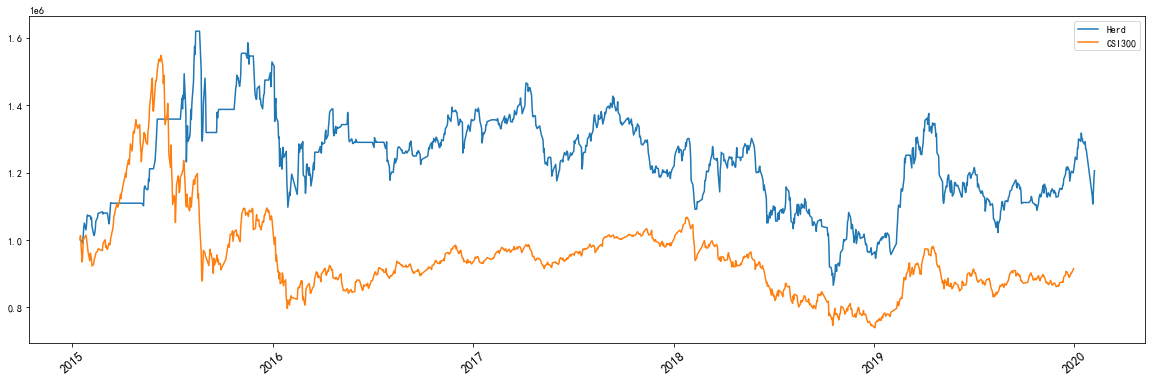

In [9]:
stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol="sh000001")
CSI300 = stock_zh_index_daily_df[(stock_zh_index_daily_df.index >= parameters_grid_dict['beginning_date']) &\
                                 (stock_zh_index_daily_df.index <= parameters_grid_dict['ending_date'])]['close']
CSI300.index = pd.to_datetime(CSI300.index, format='%Y-%m-%d').date
output.index = pd.to_datetime(output.index, format='%Y-%m-%d').date
CSI300 = CSI300/CSI300[0]*1000000
performance = pd.concat([output, CSI300], axis=1)
performance.columns = ['Herd','CSI300']
performance.plot(figsize=(20,6))
plt.xticks(size='small',rotation=40,fontsize=13)
plt.show()

<AxesSubplot:>

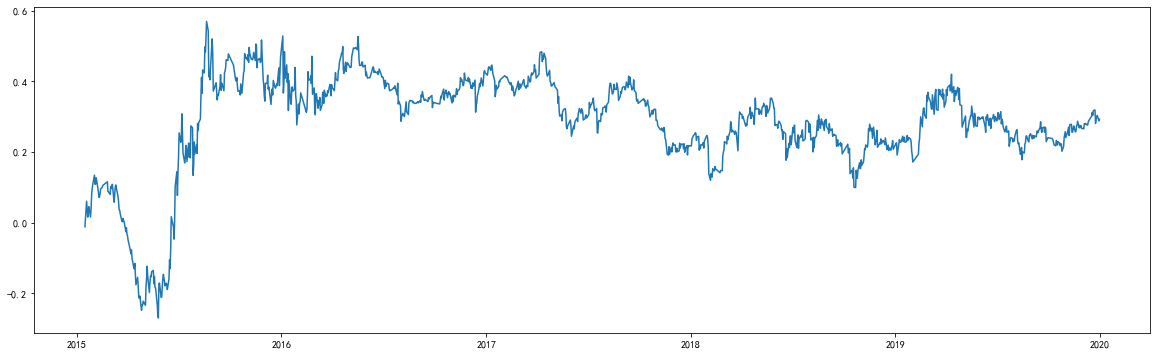

In [10]:
performance_1 = performance.dropna(axis=0, how='any')
alpha = (performance_1['Herd'] - performance_1['CSI300'])/1000000
alpha.plot(figsize=(20,6))

## Trade by Open

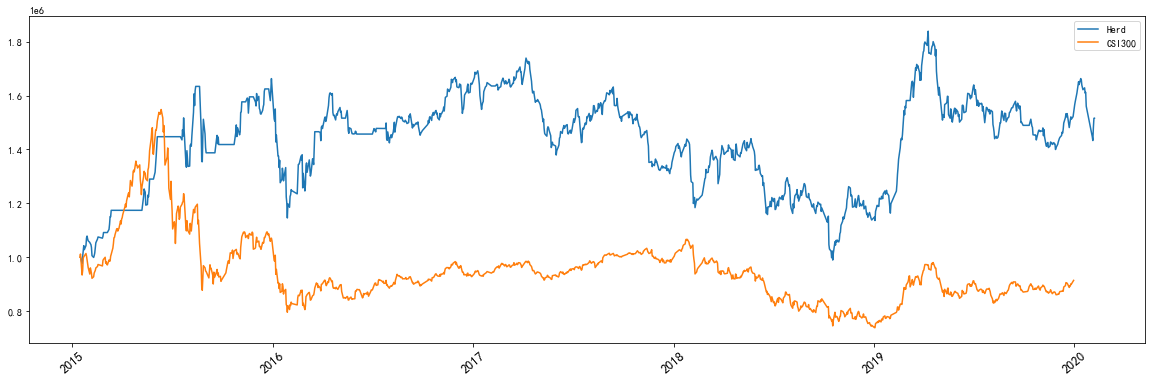

In [6]:
stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol="sh000001")
CSI300 = stock_zh_index_daily_df[(stock_zh_index_daily_df.index >= parameters_grid_dict['beginning_date']) &\
                                 (stock_zh_index_daily_df.index <= parameters_grid_dict['ending_date'])]['close']
CSI300.index = pd.to_datetime(CSI300.index, format='%Y-%m-%d').date
output.index = pd.to_datetime(output.index, format='%Y-%m-%d').date
CSI300 = CSI300/CSI300[0]*1000000
performance = pd.concat([output, CSI300], axis=1)
performance.columns = ['Herd','CSI300']
performance.plot(figsize=(20,6))
plt.xticks(size='small',rotation=40,fontsize=13)
plt.show()

<AxesSubplot:>

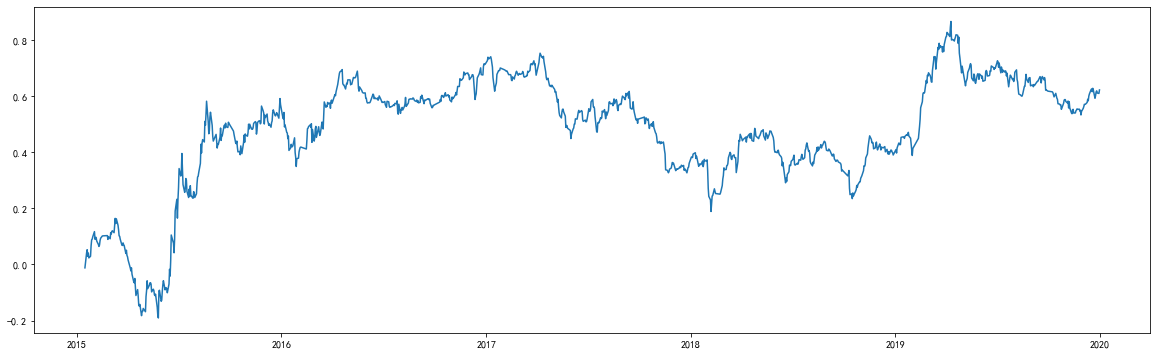

In [7]:
performance_1 = performance.dropna(axis=0, how='any')
alpha = (performance_1['Herd'] - performance_1['CSI300'])/1000000
alpha.plot(figsize=(20,6))